<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D

Import usual modules

1. Linear ($k=1$) Finite Element Method solver for the 1D Poisson problem:

$-u''=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh

FEM system assembly with trapezoidal rule for rhs

In [3]:
def FEM1_1D_TRAP(omega,N,rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with homogeneous Dirichlet bc
  # trapezoidal rule uniform grid
  # grid is defined here as uni
  h=(omega[1]-omega[0])/N
  vertices=np.linspace(omega[0],omega[1],N+1)  

  # initialise system
  A=sp.lil_matrix((N+1,N+1))
  F=np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    #ele_A by theory, not by quadrature
    ele_A=np.array([[1/h,-1/h],[-1/h,1/h]])
    ele_F=0.5*h*rhs(vertices[i:i+2])

    #assembly local to global
    A[i:i+2,i:i+2]+=ele_A
    F[i:i+2]+=ele_F
      
  # Apply boundary conditions (we divide by h to help the solver)
  A[0,0]=1/h; A[0,1]=0; F[0]=0
  A[-1,-2]=0;  A[-1,-1]=1/h; F[-1]=0

  # return system matrix and rhs vector
  return A, F

Define FEM problem and solve

In [4]:

omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

N=10; 

# call function computing FEM system
A,F=FEM1_1D_TRAP(omega,N,rhs)
Uh=sp.linalg.spsolve(A,F)
# solve

# Evaluate exact solution at grid nodes
x=np.linspace(omega[1],omega[0],N+1)
U=exact(x)
# Plot solutions

# compute discrete max norm error
print("error=",np.max(np.abs(Uh-U))) 


error= 0.0082654169662284


C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


2. Repeat exercise but using arbitrary order Gauss integration and possibly nonuniform grid

In [5]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # exploit numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

Function defining the mesh

In [6]:
#to be more general in the future
def mesh(omega,N):
  return np.linspace(omega[0],omega[1],N+1)

Define reference element transformation of coordinates

In [7]:
# Transformation of coordinates functions:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    
    # check index is within range
    assert i < len(q)-1
    assert i >= 0

    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

# Linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      phi = lambda x: 1-x
    else:
      phi = lambda x: x
    return phi

# Linear lagrange basis derivatives on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      dphi = lambda x: -np.ones(len(x))
    else:
      dphi = lambda x: np.ones(len(x))
    return dphi

FEM system assembly with Gauss integration



In [8]:
def FEM1_1D_GAUSS(omega,N,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs

  # grid
  degree=1

  vertices=mesh(omega, N)

  # quadrature formula on reference element
  q,w=quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 
  phi =np.array([basis1(i)(q) for i in range(degree+1) ]).T
  dphi =np.array([basis1_derivative(i)(q) for i in range(degree+1) ]).T

  # initialise system
  A=sp.lil_matrix((N+1,N+1))
  F=np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    JxW=mapping_J(vertices,i)*w
    ele_A=np.einsum('qi,qj,q',dphi,dphi,JxW)/mapping_J(vertices,i)**2
    ele_F=np.einsum('qi,q,q',phi,rhs(mapping(vertices,i)(q)),JxW)

    A[i:i+2,i:i+2]+=ele_A
    F[i:i+2]+=ele_F
  # return system matrix and rhs vector
  return A, F

Function implementing the boundary (nonhomogeneous) Dirichlet conditions

In [9]:
def apply_boundary_conditions(omega,N, A, F, g):
    A[0,0]=1; A[0,1]=0; F[0]=g(omega[0])
    A[-1,-2]=0;  A[-1,-1]=1; F[-1]=g(omega[1])

Define FEM problem and solve

In [10]:
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

# Initialise error vector
#Err = np.zeros(7)
#NN = np.zeros(7)
#Cond = np.zeros(7)

#for i in range(7):
  #N = 2**(i+2)
  #NN[i] = N
N=9
n_qpoints = 5

  # call function computing FEM system
A,F=FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
apply_boundary_conditions(omega,N,A,F,sol)

Uh=sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x=np.linspace(omega[1],omega[0],N+1)
U=sol(x)
# Plot solutions

# compute discrete max norm error
print("error=",np.max(np.abs(Uh-U))) 


  # solve

  #condition number of Stiffness matrix

  # Evaluate exact solution at grid nodes

  # Compute errors 

  # Plot error

error= 3.3306690738754696e-16


Function computing $H^1$-norm error

In [11]:
def FEM1_H1(omega,N,n_qpoints,Uh,sol):
  # H1 error

  # grid

  # quadrature formula on reference element


  # Evaluation of linear Lagrange basis 


  # initialise value of norm of error


  # Assembly error
  

  # Return error


IndentationError: expected an indented block (CreatorTemp/ipykernel_13164/2885247261.py, line 18)

**Exercise 1**: Try code with nonuniform grid 

In [13]:
def FEM1_1D_GAUSS_non_unif(omega,N,n_qpoints,rhs,vertices):
  # 1D FEM with k=1 system matrix and rhs

  # grid
  degree=1


  # quadrature formula on reference element
  q,w=quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 
  phi =np.array([basis1(i)(q) for i in range(degree+1) ]).T
  dphi =np.array([basis1_derivative(i)(q) for i in range(degree+1) ]).T

  # initialise system
  A=sp.lil_matrix((N+1,N+1))
  F=np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    JxW=mapping_J(vertices,i)*w
    ele_A=np.einsum('qi,qj,q',dphi,dphi,JxW)/mapping_J(vertices,i)**2
    ele_F=np.einsum('qi,q,q',phi,rhs(mapping(vertices,i)(q)),JxW)

    A[i:i+2,i:i+2]+=ele_A
    F[i:i+2]+=ele_F
  # return system matrix and rhs vector
  return A, F

C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


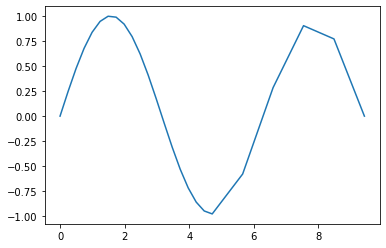

error= 0.045530985692441184


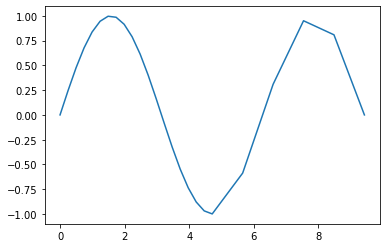

In [26]:
omega = [0,3*np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

#grid: we do something more concentrated in the first half of the domain, and less in the second
n1=20
n2=6
vert1=np.linspace(omega[0],(omega[0]+omega[1])/2,n1)
vert2=np.linspace((omega[0]+omega[1])/2,omega[1],n2)
vertices=np.concatenate([vert1[:-1],vert2],0)


N=len(vertices)-1
n_qpoints = 1

  # call function computing FEM system
A,F=FEM1_1D_GAUSS_non_unif(omega,N,n_qpoints,rhs,vertices)
apply_boundary_conditions(omega,N,A,F,sol)

Uh=sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
U=sol(vertices)
# Plot solutions
plt.plot(vertices,Uh)
plt.show()
U=sol(vertices)
plt.plot(vertices,U)
# compute discrete max norm error
print("error=",np.max(np.abs(Uh-U))) 


  # solve

  #condition number of Stiffness matrix

  # Evaluate exact solution at grid nodes

  # Compute errors 

  # Plot error

**Exercise 2**: Write code solving general reaction-advection-diffusion problems